In [1]:
import torch
import torch.nn as nn

In [2]:
class LogisticRegression(nn.Module):
    def __init__(self, dim_in: int):
        super().__init__()
        self.dim_in = dim_in
        self.linear = nn.Linear(self.dim_in, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [3]:
import numpy as np
np.random.seed(32)
weights = np.random.rand(200,1)
X_train, X_test = (np.random.rand(10000,200)-0.5), (np.random.rand(1000,200)-0.5) 
y_train = (X_train @ weights + np.random.normal(0, 2, (10000,1)) > 3).reshape(-1)
y_test = (X_test @ weights + np.random.normal(0, 2, (1000,1)) > 3).reshape(-1)

In [4]:
lr = LogisticRegression(200)
criterion = nn.BCELoss(reduction='none')
optim = torch.optim.SGD(lr.parameters(), lr=1e-2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape((10000,1))

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape((1000,1))

loss_weights = ((y_train_tensor > 0).reshape((-1,1))*10+1)


In [5]:
n_epochs = 1000
for ei in range(n_epochs):
    lr.zero_grad()
    y = lr(X_train_tensor)
    loss = (criterion(y, y_train_tensor) * loss_weights).mean()

    loss.backward()
    optim.step()
    print(loss.detach().numpy())

1.8130139
1.8098423
1.8067082
1.8036109
1.8005497
1.7975248
1.7945346
1.7915792
1.7886586
1.7857715
1.782918
1.7800972
1.7773092
1.7745532
1.7718287
1.7691356
1.7664733
1.763841
1.761239
1.7586664
1.7561231
1.7536083
1.7511221
1.7486637
1.7462329
1.7438291
1.7414523
1.739102
1.7367778
1.7344793
1.7322061
1.729958
1.7277348
1.7255358
1.7233609
1.7212095
1.7190816
1.7169768
1.7148948
1.7128352
1.7107977
1.7087821
1.7067875
1.7048148
1.7028629
1.7009317
1.6990205
1.6971297
1.6952586
1.693407
1.691575
1.6897618
1.6879674
1.6861916
1.6844338
1.6826943
1.6809725
1.679268
1.6775808
1.675911
1.6742578
1.6726213
1.6710012
1.6693969
1.6678088
1.6662363
1.6646793
1.6631379
1.6616111
1.6600994
1.6586024
1.6571199
1.6556518
1.6541977
1.6527574
1.6513308
1.649918
1.6485182
1.6471318
1.6457584
1.6443976
1.6430496
1.6417141
1.6403909
1.6390797
1.6377809
1.6364936
1.6352178
1.6339537
1.6327012
1.6314596
1.6302294
1.6290097
1.6278011
1.6266029
1.6254154
1.6242379
1.623071
1.621914
1.6207668
1.6196297
1.

In [6]:
y_pred = lr(X_train_tensor).detach().numpy().reshape(-1)

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt

In [8]:
fpr, tpr, thd = roc_curve(y_train, y_pred)

In [9]:
roc_auc_score(y_train, y_pred)

0.876178057680543

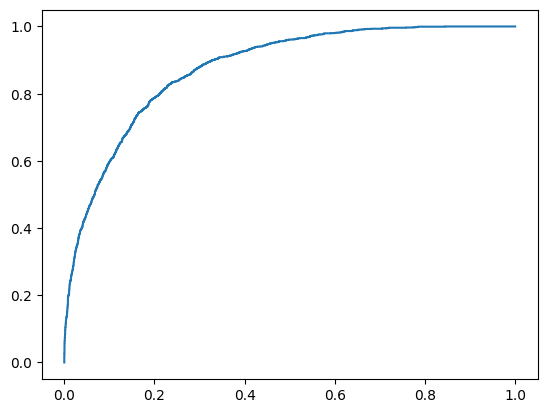

In [10]:
plt.plot(fpr, tpr)

In [11]:
y_pred = lr(X_test_tensor).detach().numpy().reshape(-1)
fpr, tpr, thd = roc_curve(y_test, y_pred)

0.8660833637136954


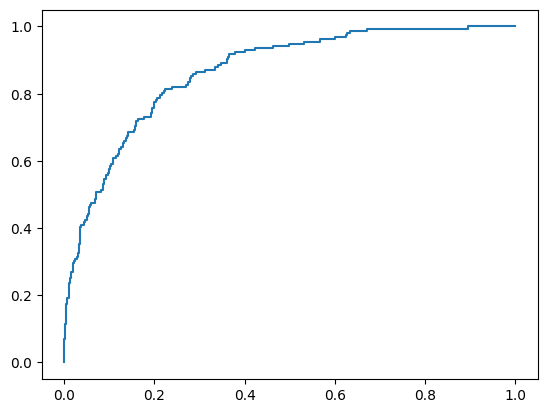

In [12]:
print(roc_auc_score(y_test, y_pred))
plt.plot(fpr, tpr)

In [13]:
w = lr.linear.weight.detach().numpy()
b = lr.linear.bias.detach().numpy()

In [44]:
prec = []
recall = []
for t in thd:
    prec.append(((y_pred>t)&(y_test)).sum()/(y_pred>t).sum())
    recall.append(((y_pred>t)&(y_test)).sum()/y_test.sum())

/var/folders/3s/p_1c0tcx30b69bz123zl11x40000gn/T/ipykernel_32242/1738942726.py:4: RuntimeWarning: invalid value encountered in scalar divide
  prec.append(((y_pred>t)&(y_test)).sum()/(y_pred>t).sum())


In [54]:
t = thd[np.where(np.array(prec)>0.7)[0].max()]

In [55]:
recall[np.where(np.array(prec)>0.7)[0].max()]

0.30128205128205127

In [56]:
(y_pred>t).mean()

0.067

# Calibration

In [69]:
qs = np.percentile(y_pred, [i*10+5 for i in range(10)])

In [86]:
pred = []
actual = []
for q1, q2 in zip([0]+list(qs), list(qs) + [1]):
    pred.append(y_pred[(y_pred < q2) & (y_pred > q1)].mean())
    actual.append(y_test[(y_pred < q2) & (y_pred > q1)].mean())

In [93]:
qs

array([0.37660161, 0.45417367, 0.51045692, 0.55420042, 0.58832007,
       0.62058126, 0.65231971, 0.68496297, 0.72929044, 0.79343655])

(0.0, 1.0)

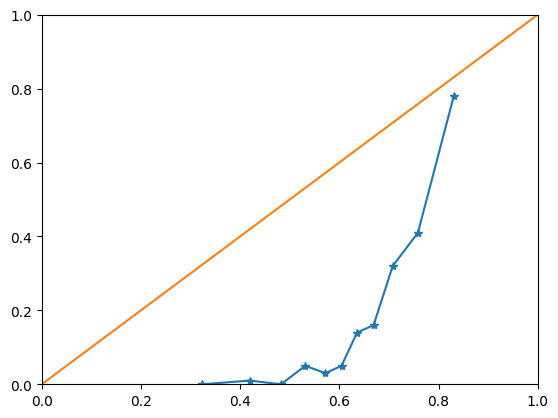

In [100]:
plt.plot(pred, actual, marker='*')
plt.plot([0]+list(qs)+[1],[0]+list(qs)+[1])
plt.xlim(0,1)
plt.ylim(0,1)

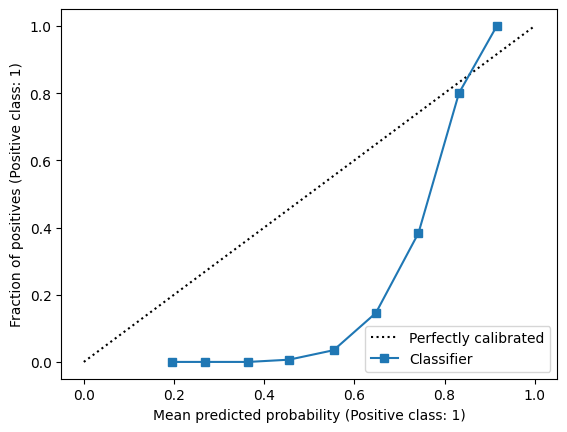

In [119]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
CalibrationDisplay.from_predictions(y_test, y_pred, n_bins=10)

(array([  7.,  21.,  63., 117., 144., 227., 203., 138.,  65.,  15.]),
 array([0.19599076, 0.26798671, 0.33998269, 0.41197866, 0.48397464,
        0.55597061, 0.62796658, 0.69996256, 0.77195853, 0.8439545 ,
        0.91595048]),
 <BarContainer object of 10 artists>)

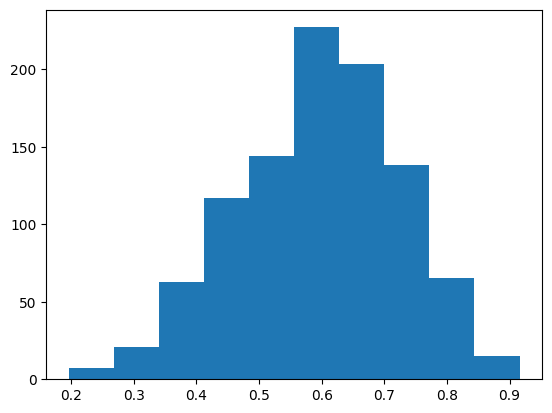

In [120]:
plt.hist(y_pred)

In [142]:
calib_m = LogisticRegression(1)

In [143]:
criterion = nn.BCELoss()
optim = torch.optim.SGD(calib_m.parameters(), lr=1e-2)

In [144]:
n_epochs = 200
for i in range(n_epochs):
    calib_m.zero_grad()
    ycalib_pred = calib_m(torch.tensor(y_pred).reshape(-1,1))
    loss = criterion(ycalib_pred, y_test_tensor)
    loss.backward()
    optim.step()

In [145]:
y_pred_calib = calib_m(torch.tensor(y_pred).reshape(-1,1)).detach().numpy().reshape(-1)

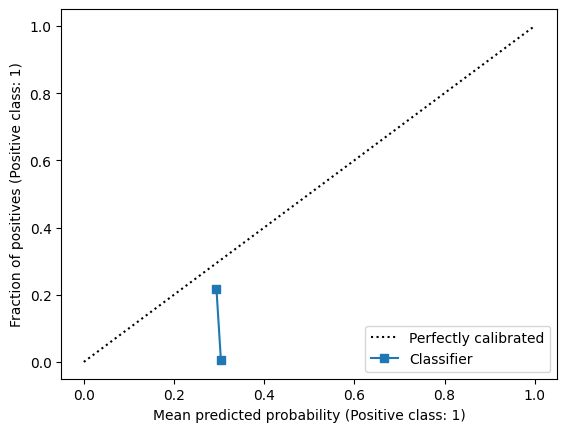

In [147]:
CalibrationDisplay.from_predictions(y_test, y_pred_calib, n_bins=10)

In [103]:
pred

[0.32375187,
 0.41916236,
 0.48238757,
 0.5314459,
 0.5720007,
 0.60450464,
 0.6356871,
 0.6691308,
 0.7076377,
 0.7584706,
 0.8307937]

In [104]:
actual

[0.0, 0.01, 0.0, 0.05, 0.03, 0.05, 0.14, 0.16, 0.32, 0.41, 0.78]

In [112]:
calibrated_prob = []
for p in y_pred:
    calibrated_prob.append(y_test[abs(y_pred-p)<0.1].mean())

In [114]:
calibrated_prob

[0.13333333333333333,
 0.03991596638655462,
 0.04233870967741935,
 0.019169329073482427,
 0.054901960784313725,
 0.06439393939393939,
 0.11371841155234658,
 0.08409506398537477,
 0.055984555984555984,
 0.0049504950495049506,
 0.06095238095238095,
 0.16573556797020483,
 0.052941176470588235,
 0.05220883534136546,
 0.003952569169960474,
 0.016339869281045753,
 0.0234192037470726,
 0.009174311926605505,
 0.18809980806142035,
 0.06779661016949153,
 0.10163339382940109,
 0.3172043010752688,
 0.5202312138728323,
 0.0,
 0.07663551401869159,
 0.48095238095238096,
 0.4131944444444444,
 0.48095238095238096,
 0.01910828025477707,
 0.3259668508287293,
 0.09041591320072333,
 0.06766917293233082,
 0.2125506072874494,
 0.12885662431941924,
 0.022900763358778626,
 0.29441624365482233,
 0.0,
 0.0867992766726944,
 0.5683453237410072,
 0.024096385542168676,
 0.2125506072874494,
 0.0922242314647378,
 0.02481389578163772,
 0.07169811320754717,
 0.14285714285714285,
 0.24557522123893805,
 0.3809523809523809

In [113]:
y_pred

array([0.62963194, 0.53276145, 0.54326445, 0.45352966, 0.56176144,
       0.5716434 , 0.61695516, 0.5893826 , 0.565913  , 0.3860145 ,
       0.56998104, 0.6637209 , 0.55628663, 0.54931617, 0.41911674,
       0.4519808 , 0.51102906, 0.3312139 , 0.6736849 , 0.5734217 ,
       0.60825765, 0.738947  , 0.81941235, 0.30520678, 0.58160126,
       0.8035704 , 0.77241987, 0.80338025, 0.45578164, 0.74180853,
       0.59773177, 0.57335764, 0.6875596 , 0.6266907 , 0.49300325,
       0.7302318 , 0.29929635, 0.590505  , 0.8331928 , 0.50113004,
       0.6879735 , 0.59931624, 0.49707058, 0.5758899 , 0.6420268 ,
       0.7057949 , 0.7630462 , 0.43659395, 0.6963759 , 0.5953861 ,
       0.75322545, 0.62653244, 0.58230025, 0.640326  , 0.6161954 ,
       0.7280269 , 0.69803923, 0.7374572 , 0.6724339 , 0.6759376 ,
       0.39961576, 0.5351659 , 0.825328  , 0.39836827, 0.54066473,
       0.81159323, 0.43915936, 0.47054422, 0.44518054, 0.65120417,
       0.46629906, 0.65405667, 0.6304015 , 0.83230186, 0.79679

In [102]:
y_test

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False,  True,  True,
       False, False,  True, False,  True,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False,  True, False,
       False,  True,  True,  True, False,  True, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,

In [101]:
y_pred

array([0.62963194, 0.53276145, 0.54326445, 0.45352966, 0.56176144,
       0.5716434 , 0.61695516, 0.5893826 , 0.565913  , 0.3860145 ,
       0.56998104, 0.6637209 , 0.55628663, 0.54931617, 0.41911674,
       0.4519808 , 0.51102906, 0.3312139 , 0.6736849 , 0.5734217 ,
       0.60825765, 0.738947  , 0.81941235, 0.30520678, 0.58160126,
       0.8035704 , 0.77241987, 0.80338025, 0.45578164, 0.74180853,
       0.59773177, 0.57335764, 0.6875596 , 0.6266907 , 0.49300325,
       0.7302318 , 0.29929635, 0.590505  , 0.8331928 , 0.50113004,
       0.6879735 , 0.59931624, 0.49707058, 0.5758899 , 0.6420268 ,
       0.7057949 , 0.7630462 , 0.43659395, 0.6963759 , 0.5953861 ,
       0.75322545, 0.62653244, 0.58230025, 0.640326  , 0.6161954 ,
       0.7280269 , 0.69803923, 0.7374572 , 0.6724339 , 0.6759376 ,
       0.39961576, 0.5351659 , 0.825328  , 0.39836827, 0.54066473,
       0.81159323, 0.43915936, 0.47054422, 0.44518054, 0.65120417,
       0.46629906, 0.65405667, 0.6304015 , 0.83230186, 0.79679